# Notebook final

## Estructura de archivos y carpetas


* **Code** *Códigos + matlab*
    * **External** *Continene JIDT*
    * **MatlabIsing** *Contiene el código de Matlab para ajuste de modelo ising*
        * **Rasters** *Contiene los rasters para usar en matlab*
        * **Models** *Contiene los modelos generados por matlab*
    * *DataDetails.json - Archivo de conjuntos*
    * *JITDWrapper.py - Wrapper para usar JITD de external*
* **Data** *Carpeta de matrices previamente guardadas*
    * **PreComputed** *Archivos calculados*
        * **MI** *Matrices de información mutua*
        * **H** *Vectores de entropía*
        * *Archivo de distancias de campos receptivos*
        * *Archivo de spikes de 4 retinas bajo 5 estímulos*
* **Documents**
    * *Propuesta - Propuesta de la solución que se propone para lograr lo esperado*
    * *Plan de Implementación - Avances progresivos en el código y propuestas*
    * *Fundamentos - Algunas detalles matemáticos de lo que se hace en el código*
            
**Estructura de nombres de archivos**
    
Se definen los nombres tanto de rasters como de modelos en matlab de la siguiente manera:

`E_C_T_N_R_P_F_S_.mat`

Luego de cada letra sigue un número o numeros que representan lo siguiente

|Letra|Número|
|---|---|
|E|Número de Retina|
|C|Estímulo presentado|
|T|Tiempo de binning|
|N|Neurona a predecir|
|R|Tipo de ranking|
|P|Porcentaje de raster|
|F|Número de neuronas|
|S|Número de sample|

Para los casos de criterio de ranking y sección de raster, el detalle es el siguiente

|Nro|Ranking|Nro|Sección|
|---|---|---|---|
|0|Aleatorio|0|100%|
|1|Aleatorio Incremental|1|70%|
|2|Información Mutua| | 
|3|Distancia de campo receptivo| | 
|4|Correlación| | 


## Secciones del código

1. **Preliminares**
    1. Imports
    2. Definición de parametros fijos
    3. Carga/Cómputo de variables almacenadas de uso constante
2. **Selección de neuronas**
    1. Carga de archivo de conjunto de neuronas **(*)**
    2. Computa los conjuntos de neuronas
        1. Aleatorio (5 x 10/20/50/100/120/150)
        2. Aleatorio Incremental (5 x 10/20/50/100/120/150)
        3. En base a información Mutua (1 x 1:10/20/50/100/120/150)
        4. En base a Correlación (1 x 1:10/20/50/100/120/150)
        5. En base a Distancia de Campos receptivos (1 x 1:10/20/50/100/120/150)
3. **Creación de Modelos (\*\*)**
    1. Exportar rasters a formato MATLAB
        1. En formato Completo/Train 70%
    2. Exportar las lineas de código para ejecutar sobre MATLAB
    3. Ejecutar MATLAB **(Externo)**
4. **Cálculo de predicciónes**
    1. Función de predicción de raster en base a modelo
    2. Llamadas a la función de preducción y guardado de resultados
5. **Cálculo de métricas**
    1. Función de cálculo de métricas en base a resultados
    2. Llamadas a función de cálculo de métricas y guardado de resultados
6. **Gráficos**
    1. Visualizar predicciones v/s datos originales
    2. Obtener graficos de las métricas según distintos parámetros
    3. Obtener los espacios de las métricas
7. **Adicionales**
    1. Eliminación de rasters **(\*\*\*)**
    
**(*)** = Sólo si el archivo existe, o de lo contrario se generará uno en el punto 2.

**(\*\*)** = Es necesario hacer esto sólo una vez.

**(\*\*\*)** = Los rasters de matlab sólo se utilizan en el punto 3 y luego se trabaja con los modelos, su generación puede ser muy pesada. En caso de necesitarse nuevamente su generación es rápida y se basa en el archivo de conjuntos del punto 2.

In [248]:
### 1 - Preliminares

#### Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import os
from matplotlib.ticker import ScalarFormatter
from ipywidgets import interact
from scipy.io import loadmat,savemat
from scipy.ndimage.filters import gaussian_filter1d
from scipy import sparse
from json import loads,dumps
from jpype import *
from JITDWrapper import *
%matplotlib inline

#### Parámetros Fijos
EXP = 0 # 0 1 2 3
COND = 3 # 0.issa 1.ifsa 2.wn 3.nm 4.ffsa 5. fssa
TBASE = 0.02 #0.001 = 1ms
RASTER = dataLoader(EXP,COND,TBASE)[0]
INTERVAL = 50 # para SpRate
N,T = RASTER.shape
J = 5
NsR = [10,20,50,100,120,N-1]
Ns = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,N-1]

#### Cargas iniciales

D = loadmat("../Data/rfOverlap.mat")["rfDist"][0][0]
MI = MutualInformation(EXP,COND,TBASE)
CC = np.corrcoef(RASTER[:50],RASTER[50:])**2-np.diag(np.ones(N))

Returning saved sparse matrix E0_C3_T0.02
Returning PreComputed MIMatrix E0_C3_T0.02


In [250]:
### 2 - Selección de neuronas
#### Carga de archivo
if "DataDetails.json" in os.listdir():
    with open("DataDetails.json") as DD:
        dataset = loads(DD.readline())
    print("Carga de archivo existente")

#### Creación de Archivo
else:
    fixed = int(np.random.choice(range(N)))
    free = np.array(list(set(range(N))-{fixed}))
    mienum = sorted([(x[1],x[0]) for x in enumerate(MI[fixed])],reverse=1) #mayor a menor
    miids = list([x[1] for x in mienum])
    miids.remove(fixed)
    cenum = sorted([(x[1],x[0]) for x in enumerate(CC[fixed])],reverse=1)
    cids = list([x[1] for x in cenum])[:-1]
    denum = sorted([(x[1],x[0]) for x in enumerate(D[fixed])])
    dids = list([x[1] for x in denum])[1:]
    dataset = {"fixed":fixed,
               0:dict([(n,[sorted(np.random.choice(free,n,False).tolist()) for j in range(J)]) for n in NsR]),
               1:{},
               2:dict([(n,[[fixed]+miids[:n]]) for n in Ns]),
               3:dict([(n,[[fixed]+dids[:n]]) for n in Ns]),
               4:dict([(n,[[fixed]+cids[:n]]) for n in Ns])} 
    newsets=[np.random.choice(list(set(range(N))-{fixed}),N-1,False).tolist() for j in range(J)]
    for n in NsR:
        dataset[1][n]=[]
        for j in range(J):
            dataset[1][n].append(newsets[j][:n])
with open("DataDetails.json","w") as DD:
    DD.write(dumps(dataset))
    
#dataset = {#tipo_selección:{#neuronas:[sample0,sample1,...]}} sampleN = [id0,id1,id2,...]

Carga de archivo existente


In [260]:
### 3 - Creación de modelos
#### Código para exportar a archivos MATLAB
for rank in [0,1,2,3,4]: #tipo de ranking
    if rank in [0,1]:
        flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
    else:
        flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]
    for f in flist: #neuronas fijadas
        for s in slist: #samples
            savemat("MatlabIsing/Rasters/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,dataset["fixed"],rank,0,f,s),
                    {"binnedSpikes":RASTER[[dataset["fixed"]]+dataset[str(rank)][str(f)][s],:]})
            savemat("MatlabIsing/Rasters/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,dataset["fixed"],rank,1,f,s),
                    {"binnedSpikes":RASTER[[dataset["fixed"]]+dataset[str(rank)][str(f)][s],:int(T*0.7)]})
            print ("Guardado MatlabIsing/Rasters/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,dataset["fixed"],rank,0,f,s))

Guardado MatlabIsing/Rasters/E0C3T0.02N127R0P0F150S4.mat
Guardado MatlabIsing/Rasters/E0C3T0.02N127R1P0F150S4.mat
Guardado MatlabIsing/Rasters/E0C3T0.02N127R2P0F150S0.mat
Guardado MatlabIsing/Rasters/E0C3T0.02N127R3P0F150S0.mat
Guardado MatlabIsing/Rasters/E0C3T0.02N127R4P0F150S0.mat


In [262]:
#### Código para generar las lineas ejecutables en MATLAB
for rank in [0,1,2,3,4]: #tipo de ranking
    if rank in [0,1]:
        flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
    else:
        flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]
    for f in flist: #neuronas fijadas
        for s in slist: #samples
            print ("Ajustar('{0}','{1}','{2}');".format('Rasters','Models',
                                                        "E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,dataset["fixed"],rank,0,f,s)))
            print ("Ajustar('{0}','{1}','{2}');".format('Rasters','Models',
                                                        "E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,dataset["fixed"],rank,1,f,s)))

Ajustar('Rasters','Models','E0C3T0.02N127R0P0F10S0.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P1F10S0.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P0F10S1.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P1F10S1.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P0F10S2.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P1F10S2.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P0F10S3.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P1F10S3.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P0F10S4.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P1F10S4.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P0F20S0.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P1F20S0.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P0F20S1.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P1F20S1.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P0F20S2.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P1F20S2.mat');
Ajustar('Rasters','Models','E0C3T0.02N127R0P0F20S3.mat');
Ajustar('Raste

In [284]:
### 4 - Cómputo de predicciones
#### Función de predicción de raster o spikerate en base al modelo

def PredecirSpRate(r,p,f,s,pp): #neurona,ranking,particion_entreno,fijas,set,particion_eval
    #Carga indices de neuronas y ajusta datos
    neuronas = [dataset["fixed"]]+dataset[str(r)][str(f)][s]
    if pp == 0: #full
        data = RASTER[neuronas,:]
    elif pp == 1: #Partial Training
        data = RASTER[neuronas,:int(T*0.7)]
    else: #Partial Testing
        data = RASTER[neuronas,int(T*0.7):]

    #Carga el modelo
    ising = loadmat("MatlabIsing/Models/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,dataset["fixed"],r,p,f,s))
    params = ising["params"] # N , N*(N-1)/2
    P = np.zeros((N,N)) #FullMatrix for indexing
    P[np.triu_indices(N, 1)] = params[:,0][N:] #UpperTri Matrix
    P = P+np.diag(params[:,0][:N]) #<h,sigma>
    #Calcula la probabilidad
    obtRate = []
    for t in range(data.T.shape[0]):
        selected = np.array([[1.0]+data.T[t][1:N].tolist(), [0.0]+data.T[t][1:N].tolist()]) # 1/0 + data 1:N
        prob_denom = np.sum(np.exp(np.sum(np.matmul(selected,P)*selected,1))) #Prob P(given)
        selected = np.array([[1.0]+data.T[t][1:N].tolist()]) #1 + data 1:N
        prob_num = np.sum(np.exp(np.sum(np.matmul(selected,P)*selected,1))) #Prob P(target,given)
        obtRate.append(prob_num/prob_denom)
    
    spRate = np.array([np.sum(data[0][i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    spRatePred = np.array([np.sum(obtRate[i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    if 1: #PLOT
        plt.figure(figsize=(15,3))
        plt.title("SpikeRate en base a Modelo: "+"E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,dataset["fixed"],r,p,f,s))
        plt.xlabel("T")
        plt.ylabel("SpikeRate")
        plt.plot(range(T-50),gaussian_filter1d(spRate, sigma=3),"r",alpha=0.1)
        plt.plot(range(T-50),gaussian_filter1d(spRatePred,sigma=3))
        plt.show()
    return obtRate,spRatePred

#### Llamado a la función y almacenamiento de predicción

predicciones = {}
for r in [0,1,2,3,4]: #tipo de ranking
    if r in [0,1]:
        flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
    else:
        flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]
    for f in flist: #neuronas fijadas
        for s in slist: #samples
            for p in [0,1]:
                if p==0:
                    predicciones[(r,p,f,s,0)] = PredecirSpRate(r,p,f,s,0) #Full a Full
                else:
                    predicciones[(r,p,f,s,1)] = PredecirSpRate(r,p,f,s,1) #Partial a Partial
                    predicciones[(r,p,f,s,2)] = PredecirSpRate(r,p,f,s,2) #Partial a Testing

#predicciones = {}

'\nallPredictions = {}\nfor r in [0,1,2,3,4]: #tipo de ranking\n    if r in [0,1]:\n        flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]\n    else:\n        flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]\n    for f in flist: #neuronas fijadas\n        for s in slist: #samples\n            for p in [0,1]:\n                if p==0:\n                    allPredictions[(r,p,f,s,0)] = PredecirSpRate(r,p,f,s,0) #Full a Full\n                else:\n                    allPredictions[(r,p,f,s,1)] = PredecirSpRate(r,p,f,s,1) #Partial a Partial\n                    allPredictions[(r,p,f,s,2)] = PredecirSpRate(r,p,f,s,2) #Partial a Testing\n'

In [282]:
### 5 - Cálculo de métricas
#### Función para calcular las métricas en base a una predicción
def ObtenerMetricas(r,p,f,s,pp):
    if pp == 0: #full
        data = RASTER[neuronas,:]
        spRate = np.array([np.sum(data[0][i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    elif pp == 1: #Partial Training
        data = RASTER[neuronas,:int(T*0.7)]
        np.array([np.sum(data[0][i:i+50]) for i in range(0,int(T*0.7)-50)])/(1/TBASE)
    else: #Partial Testing
        data = RASTER[neuronas,int(T*0.7):]
        np.array([np.sum(data[0][i:i+50]) for i in range(0,int(T*0.3)-50)])/(1/TBASE)
    preData,preSp = allPredictions[(r,p,f,s,pp)]
    dataDist = np.round(np.linalg.norm(data-preData))
    dataR = np.round(np.corrcoef(data,preData))
    spDist = np.round(np.linalg.norm(data-preData))
    spR = np.round(np.corrcoef(data,preData))
    return [(dataDist,dataR),(spDist,spR)]
    
#### Llamados a función de cálculo de metricas y almacenamiento de los resultados
medidas = {}
for r in [0,1,2,3,4]: #tipo de ranking
    if r in [0,1]:
        flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
    else:
        flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]
    for f in flist: #neuronas fijadas
        for s in slist: #samples
            for p in [0,1]: #particiones
                medidas[(r,p,f,s,0)] = ObtenerMetricas(r,p,f,s,0) #de full a full
                medidas[(r,p,f,s,1)] = ObtenerMetricas(r,p,f,s,1) #de parcial a training
                medidas[(r,p,f,s,2)] = ObtenerMetricas(r,p,f,s,2) #de parcial a testing

#medidas = {}

In [ ]:
### 6 - Generación de visualizaciones
#### Función de visualización de raster/spRate v/s su predicción correspondiente

#### Función para visualizar las métricas de rendimiento de las predicciones

#### Función para visualizar los espacios de métricas utilizadas

#### Función para visualizar la caracterización de una neurona (Activación,EspacioMI,EspacioR,EspacioRF)


In [ ]:
### 7 - Misc
#### Función para eliminar todos los rasters generados para MATLAB
# idea chantar un os.system -> rm recursivo para los .mat dentro de Rasters


# No considerar de acá hacia abajo

In [173]:
def autocorrelate(V,lags=None):
    V = V/np.linalg.norm(V)
    if lags == None:
        return np.correlate(V,V,"full")
    return np.correlate(V,V,"full")[int(len(V)-lags)-1:int(len(V)+lags)]
def spr(V,I):
    return np.array([np.sum(V[i:i+I]) for i in range(0,len(V)-I)])/(1/TBASE)
#SpikeRates
sprates = [spr(RASTER[i],50) for i in range(N)]

LAGS = 1600
#plt.figure(figsize=(25,3))
#plt.plot(np.arange(-LAGS,LAGS+1,1),np.sum([autocorrelate(sprates[i],LAGS) for i in range(N)],axis=0)/N)

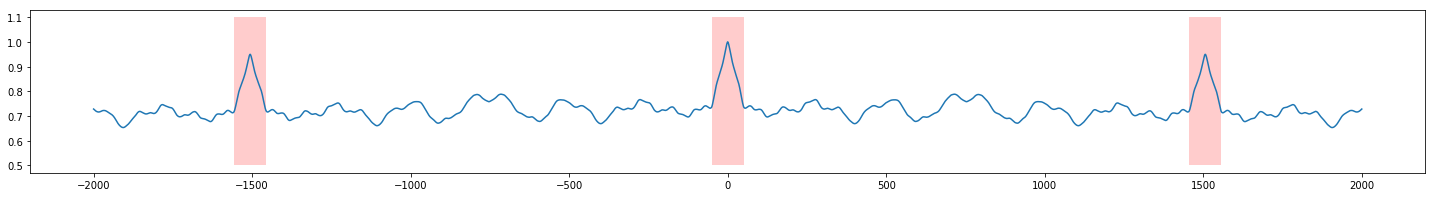

In [105]:
plt.figure(figsize=(25,3))
plt.plot(np.arange(-2000,2001),autocorrelate(sprates[5],2000))
plt.fill([-50,-50,50,50],[0.5,1.1,1.1,0.5],"r",alpha=0.2)
plt.fill([-1556,-1556,-1456,-1456],[0.5,1.1,1.1,0.5],"r",alpha=0.2)
plt.fill([1556,1556,1456,1456],[0.5,1.1,1.1,0.5],"r",alpha=0.2)

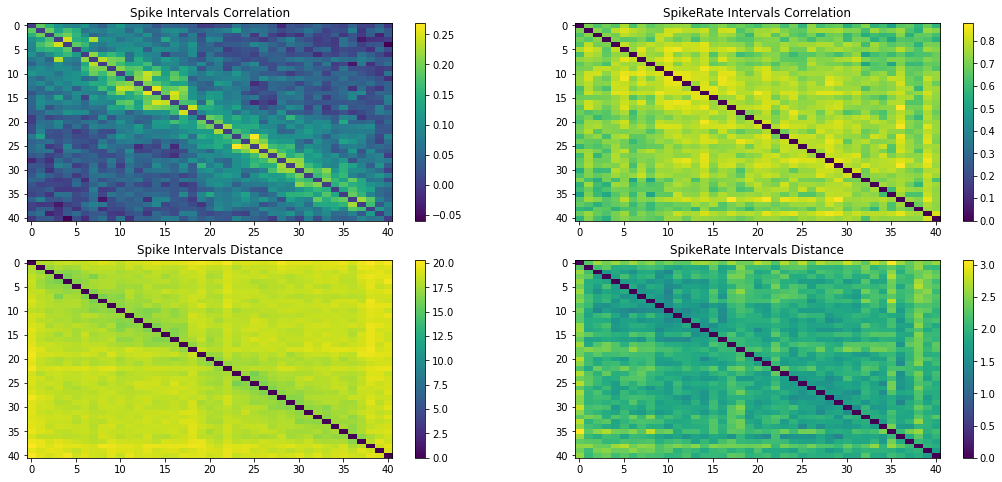

In [233]:
spli = np.split(RASTER[3][:-63],41)
splispr = np.split(spr(RASTER[3],50)[:-13],41)
plt.figure(figsize=(18,8))
plt.subplot(2,2,1)
plt.title("Spike Intervals Correlation")
MAT = np.array([[ np.corrcoef(j,i)[0][1] for j in spli] for i in spli])-np.diag(np.ones(41))
plt.imshow(MAT,aspect="auto")
plt.colorbar()
plt.subplot(2,2,2)
plt.title("SpikeRate Intervals Correlation")
MAT = np.array([[ np.corrcoef(j,i)[0][1] for j in splispr] for i in splispr])-np.diag(np.ones(41))
plt.imshow(MAT,aspect="auto")
plt.colorbar()
plt.subplot(2,2,3)
plt.title("Spike Intervals Distance")
MAT = np.array([[ np.linalg.norm(j-i) for j in spli] for i in spli])
plt.imshow(MAT,aspect="auto")
plt.colorbar()
plt.subplot(2,2,4)
plt.title("SpikeRate Intervals Distance")
MAT = np.array([[ np.linalg.norm(j-i) for j in splispr] for i in splispr])
plt.imshow(MAT,aspect="auto")
plt.colorbar()


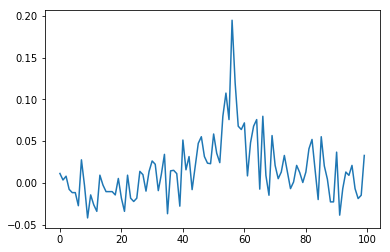

In [179]:
plt.plot(range(100),[np.corrcoef(RASTER[3][:2000],RASTER[3][1506+i:3450+i])[0,1] for i in range(100)])

In [242]:
X = np.random.randint(2,30,12316).tolist()

In [243]:
Xtr = X[:int(len(X)*0.7)]
Xte = X[int(len(X)*0.7):]
print(X == Xtr+Xte)
print(len(Xtr),len(Xte),len(X))

True
8621 3695 12316


In [288]:
allmods = os.listdir("MatlabIsing/Models/")
for rank in [0,1,2,3,4]: #tipo de ranking
    if rank in [0,1]:
        flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
    else:
        flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]
    for f in flist: #neuronas fijadas
        for s in slist: #samples
            for p in [0,1]:
                nom = "E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,dataset["fixed"],rank,p,f,s)
                print (nom,nom in allmods)

E0C3T0.02N127R0P0F10S0.mat True
E0C3T0.02N127R0P1F10S0.mat True
E0C3T0.02N127R0P0F10S1.mat True
E0C3T0.02N127R0P1F10S1.mat True
E0C3T0.02N127R0P0F10S2.mat True
E0C3T0.02N127R0P1F10S2.mat True
E0C3T0.02N127R0P0F10S3.mat True
E0C3T0.02N127R0P1F10S3.mat True
E0C3T0.02N127R0P0F10S4.mat True
E0C3T0.02N127R0P1F10S4.mat True
E0C3T0.02N127R0P0F20S0.mat True
E0C3T0.02N127R0P1F20S0.mat True
E0C3T0.02N127R0P0F20S1.mat True
E0C3T0.02N127R0P1F20S1.mat True
E0C3T0.02N127R0P0F20S2.mat True
E0C3T0.02N127R0P1F20S2.mat True
E0C3T0.02N127R0P0F20S3.mat True
E0C3T0.02N127R0P1F20S3.mat True
E0C3T0.02N127R0P0F20S4.mat True
E0C3T0.02N127R0P1F20S4.mat True
E0C3T0.02N127R0P0F50S0.mat True
E0C3T0.02N127R0P1F50S0.mat True
E0C3T0.02N127R0P0F50S1.mat True
E0C3T0.02N127R0P1F50S1.mat True
E0C3T0.02N127R0P0F50S2.mat True
E0C3T0.02N127R0P1F50S2.mat True
E0C3T0.02N127R0P0F50S3.mat True
E0C3T0.02N127R0P1F50S3.mat True
E0C3T0.02N127R0P0F50S4.mat True
E0C3T0.02N127R0P1F50S4.mat True
E0C3T0.02N127R0P0F100S0.mat True
E0C3T0.